In [129]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import pickle

from scipy.interpolate import SmoothBivariateSpline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# Step 1: Generate Synthetic Data
n_samples = 10000
X, y = make_blobs(n_samples=n_samples, centers=2, cluster_std=1.5, random_state=42)


In [130]:
with open('data/reset_splines.pkl', 'rb') as f:
    reset_splines = pickle.load(f)
with open('data/set_splines.pkl', 'rb') as f:
    set_splines = pickle.load(f)

In [131]:

# Standardize the dataset
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)


In [132]:

# Step 2: Define the MLP Model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(2, 16)  # Input layer (2 features) to hidden layer (16 neurons)
        self.fc2 = nn.Linear(16, 2)   # Hidden layer (16 neurons) to output layer (2 classes)

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # Activation function for hidden layer
        x = self.fc2(x)               # No activation for output layer
        return x


In [133]:
class HardwareAwareOptimizer(torch.optim.Optimizer):
    def __init__(self, params, lr=0.01, set_splines=None, reset_splines = None):
        defaults = dict(lr=lr)
        self.set_splines = set_splines
        self.reset_splines = reset_splines
        super(HardwareAwareOptimizer, self).__init__(params, defaults)

    def step(self):
        def map_weights_to_conductance(weight, min_weight, max_weight, min_conductance, max_conductance):
            # Linear interpolation from weight to conductance
            normalized_weights = (weight - min_weight) / (max_weight - min_weight)
            mapped_conductance = min_conductance + normalized_weights * (max_conductance - min_conductance)
            mapped_conductance = torch.clamp(mapped_conductance, min_conductance, max_conductance)
            return mapped_conductance
        
        # def new_conductance(G0, grad):
            
        #     # G_pos = G0*1.05
        #     # G_neg = G0*(0.95)
        #     # Apply the splines based on gradient
        #     positive_mask = torch.le(grad, 0)  # Check for grad >= 0
        #     G_pos = G0 * (self.set_splines['1 us'].ev(G0, 2.5))
        #     G_neg = G0 * (self.reset_splines['1 us'].ev(G0, -2.5))
            
        #     # # Combine both positive and negative cases
        #     G_new = torch.where(positive_mask, G_pos, G_neg)
        #     return G_new
        def new_conductance(G0, grad):
            
            tau = 0.01
            # Masks for set, reset, and no change conditions
            set_mask = torch.ge(grad, tau)       # Apply set spline if grad >= tau
            reset_mask = torch.le(grad, -tau)    # Apply reset spline if grad <= -tau

            # Apply the set and reset splines
            G_pos = G0 * self.reset_splines['1 us'].ev(G0, -2.5)    # Set spline adjustment
            G_neg = G0 * self.set_splines['1 us'].ev(G0, 2.5) # Reset spline adjustment

            # Use torch.where to select G_pos, G_neg, or G0 based on conditions
            G_new = torch.where(set_mask, G_pos, torch.where(reset_mask, G_neg, G0))

            return G_new

        def map_conductance_to_weights(conductance, min_conductance, max_conductance, min_weight, max_weight):
            # Reverse mapping from conductance to weight

            normalized_conductance = (conductance - min_conductance) / (max_conductance - min_conductance)
            mapped_weight = min_weight + normalized_conductance * (max_weight - min_weight)
            mapped_weight = torch.clamp(mapped_weight, min_weight, max_weight)
            return mapped_weight

        def map_weights_to_conductance_sine(weight, min_weight, max_weight, min_conductance, max_conductance):
            mid_weight = (max_weight+min_weight)/2
            mid_conductance = (max_conductance + min_conductance)/2
            normalized_weight = (weight - mid_weight)/(max_weight-mid_weight)
            # normalized_conductance = 2/torch.pi * torch.arcsin(normalized_weight)
            # normalized_conductance = normalized_weight ** 3
            normalized_conductance = normalized_weight
            conductance = normalized_conductance * (max_conductance - mid_conductance) + mid_conductance
            return conductance
        
        def map_conductance_to_weights_sine(conductance, min_weight, max_weight, min_conductance, max_conductance):
            mid_weight = (max_weight+min_weight)/2
            mid_conductance = (max_conductance + min_conductance)/2
            normalized_conductance = (conductance - mid_conductance)/(max_conductance - mid_conductance)
            # normalized_weight = torch.sin(normalized_conductance * torch.pi/2)
            # normalized_weight = torch.sign(normalized_conductance) * torch.abs(normalized_conductance) ** (1/3)
            normalized_weight = normalized_conductance
            weight = normalized_weight*(max_weight - mid_weight) + mid_weight
            return weight



        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue

                min_weight, max_weight = -1.5, 1.5
                min_conductance, max_conductance = 5e-7, 3e-6
                
                # Get the current weights and gradients
                weight, grad = p.data, p.grad.data

                # 1. Map weights to conductance values
                G0 = map_weights_to_conductance_sine(
                    weight=weight,
                    min_weight=min_weight,
                    max_weight=max_weight,
                    min_conductance=min_conductance,
                    max_conductance=max_conductance
                )

                # 2. Modify conductance using spline function based on the gradient
                G_new = new_conductance(G0=G0, grad=grad)

                # 3. Map the new conductance values back to weights
                new_weight = map_conductance_to_weights_sine(
                    conductance=G_new,
                    min_conductance=min_conductance,
                    max_conductance=max_conductance,
                    min_weight=min_weight,
                    max_weight=max_weight
                )
                
                # Update the weights in the optimizer
                p.data.copy_(new_weight)  # In-place update of the weights


In [134]:
def map_weights_to_conductance(weight, min_weight, max_weight, min_conductance, max_conductance):
            # Element-wise comparison for tensors
            weight = torch.clamp(weight, min=min_weight, max=max_weight)  # Clamp the weight between min and max weight
            
            normalized_weights = (weight - min_weight) / (max_weight - min_weight)
            
            # Map normalized values to [min_conductance, max_conductance] range
            mapped_conductance = min_conductance + normalized_weights * (max_conductance - min_conductance)
            mapped_conductance = torch.clamp(mapped_conductance, min_conductance, max_conductance)
            
            return mapped_conductance
def new_conductance(G0, grad):
            # G_new = G0 * (1 + (0.05 if grad>0 else -0.05))
        #     # Create a mask where grad >= 0
            positive_mask = torch.ge(grad, 0)  # Element-wise comparison
            
        #     # For grad >= 0, use the set_splines function
            G_new_positive = G0 * (set_splines['10 us'].ev(G0, 2.5)  )
            
        #     # For grad < 0, use the reset_splines function
            G_new_negative = G0 * (reset_splines['10 us'].ev(G0, -2.5) )
        #     # Combine the two based on the mask
            G_new = torch.where(positive_mask, G_new_positive, G_new_negative)
            
            return G_new

def map_weights_to_conductance_sine(weight, min_conductance, max_conductance, min_weight, max_weight):
        mid_weight = (max_weight+min_weight)/2
        mid_conductance = (max_conductance + min_conductance)/2
        normalized_weight = (weight - mid_weight)/(max_weight-mid_weight)
        normalized_conductance = 2/np.pi * torch.arcsin(normalized_weight)
        conductance = normalized_conductance * (max_conductance - mid_conductance) + mid_conductance
        return conductance


def map_conductance_to_weights_sine(conductance, min_conductance, max_conductance, min_weight, max_weight):
    mid_weight = (max_weight+min_weight)/2
    mid_conductance = (max_conductance + min_conductance)/2
    normalized_conductance = (conductance - mid_conductance)/(max_conductance - mid_conductance)
    normalized_weight = torch.sin(normalized_conductance * torch.pi/2)
    weight = normalized_weight*(max_weight - mid_weight) + mid_weight
    return weight
def map_conductance_to_weights(conductance, min_conductance, max_conductance, min_weight, max_weight):
            normalized_conductance = (conductance - min_conductance) / (max_conductance - min_conductance)
            mapped_weight = min_weight + normalized_conductance * (max_weight - min_weight)
            mapped_weight = torch.clamp(mapped_weight, min_weight, max_weight)
            return torch.tensor(mapped_weight)

min_weight, max_weight = -1.5, 1.5
min_conductance, max_conductance = 5e-7, 6e-6

for weight in torch.linspace(min_weight, max_weight, 16):
        
    weight, grad = torch.tensor(weight), torch.tensor(-0.1)
    G0 = map_weights_to_conductance_sine(
                        weight=weight,
                        min_weight=min_weight,
                        max_weight=max_weight,
                        min_conductance=min_conductance,
                        max_conductance=max_conductance
        )
                    
                    # Update conductance based on gradient
    G_new = new_conductance(G0=G0, grad=grad)
    new_weight = map_conductance_to_weights_sine(
                        conductance=G_new,
                        min_conductance=min_conductance,
                        max_conductance=max_conductance,
                        min_weight=min_weight,
                        max_weight=max_weight
    )
    print(f"Weight = {weight}, new_weight = {new_weight}")

Weight = -1.5, new_weight = -1.4999980312085814
Weight = -1.2999999523162842, new_weight = -1.316598315675673
Weight = -1.100000023841858, new_weight = -1.09742555247528
Weight = -0.8999999761581421, new_weight = -0.8868332733552109
Weight = -0.699999988079071, new_weight = -0.7108627120142335
Weight = -0.5, new_weight = -0.5832608261916794
Weight = -0.2999999523162842, new_weight = -0.5100816517382472
Weight = -0.10000002384185791, new_weight = -0.49287349377656503
Weight = 0.10000002384185791, new_weight = -0.5303894334715291
Weight = 0.2999999523162842, new_weight = -0.6188966951361772
Weight = 0.5, new_weight = -0.7512923153725335
Weight = 0.699999988079071, new_weight = -0.9154059967214672
Weight = 0.8999999761581421, new_weight = -1.0922045367565982
Weight = 1.100000023841858, new_weight = -1.2551024374734217
Weight = 1.2999999523162842, new_weight = -1.370881827397246
Weight = 1.5, new_weight = -1.2246057251987155


C:\Users\adith\AppData\Local\Temp\ipykernel_19792\977570419.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weight, grad = torch.tensor(weight), torch.tensor(-0.1)


In [135]:

# def map_conductance_to_weights(conductance, min_conductance, max_conductance, min_weight, max_weight):
#     normalized_conductance = (conductance - min_conductance) / (max_conductance - min_conductance)
#     mapped_weight = min_weight + normalized_conductance * (max_weight - min_weight)
#     return torch.clamp(mapped_weight, min_weight, max_weight)

# # Example gradient update function (needs to be properly defined)
# def new_conductance(G0, grad):
#     # Simulate a conductance update using the gradient (example logic, modify as needed)
#     return G0 + grad * 5e-7  # Adjust based on the problem's needs

# Set up constants
min_weight, max_weight = -1.5, 1.5
min_conductance, max_conductance = 5e-7, 6e-6

# Loop through weights, apply mapping, update conductance, and map back to weights
for weight in torch.linspace(-1.5, 1.5, 11):
    weight = torch.tensor(weight)
    grad = torch.tensor(-0.3)
    
    # Map weight to initial conductance
    G0 = map_weights_to_conductance(weight, min_weight, max_weight, min_conductance, max_conductance)
    # Update conductance based on gradient (use actual logic for your use case)
    G_new = new_conductance(G0=G0, grad=grad)
    
    # Map updated conductance back to weight
    new_weight = map_conductance_to_weights(G_new, min_conductance, max_conductance, min_weight, max_weight)
    
    print(f"Weight = {weight}, G0 = {G0}, G_new = {G_new}, new weight = {new_weight}")

Weight = -1.5, G0 = 4.999999987376214e-07, G_new = 5.028365525846791e-07, new weight = -1.4984527894992659
Weight = -1.2000000476837158, G0 = 1.0499999234525603e-06, G_new = 9.944985189972558e-07, new weight = -1.230273535092406
Weight = -0.8999999761581421, G0 = 1.6000001323845936e-06, G_new = 1.5807984606047244e-06, new weight = -0.9104735669428775
Weight = -0.5999999642372131, G0 = 2.1500000002561137e-06, G_new = 2.168234208126821e-06, new weight = -0.590054068294461
Weight = -0.2999999523162842, G0 = 2.7000000955013093e-06, G_new = 2.572921355319898e-06, new weight = -0.36931562437096455
Weight = 0.0, G0 = 3.2499999633728294e-06, G_new = 2.64890111202757e-06, new weight = -0.3278721207122346
Weight = 0.2999999523162842, G0 = 3.7999998312443495e-06, G_new = 2.3677194836273052e-06, new weight = -0.4812439180214698
Weight = 0.5999999642372131, G0 = 4.349999926489545e-06, G_new = 1.8492718934558029e-06, new weight = -0.7640335126604713
Weight = 0.8999999761581421, G0 = 4.90000047648209

C:\Users\adith\AppData\Local\Temp\ipykernel_19792\2925088664.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weight = torch.tensor(weight)
C:\Users\adith\AppData\Local\Temp\ipykernel_19792\977570419.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(mapped_weight)


In [136]:

# Create the model
model = MLP()
# Step 3: Train the Model
criterion = nn.CrossEntropyLoss()  # Loss function
optimizer = HardwareAwareOptimizer(model.parameters(), lr=0.01, set_splines=set_splines, reset_splines=reset_splines)

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    optimizer.zero_grad()  # Clear gradients
    outputs = model(X_train_tensor)  # Forward pass
    loss = criterion(outputs, y_train_tensor)  # Compute loss
    loss.backward()  # Backward pass
    optimizer.step()  # Update weights

    if (epoch + 1) % 2 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [2/20], Loss: 0.2254
Epoch [4/20], Loss: 0.0259
Epoch [6/20], Loss: 0.0173
Epoch [8/20], Loss: 0.0173
Epoch [10/20], Loss: 0.0173
Epoch [12/20], Loss: 0.0173
Epoch [14/20], Loss: 0.0173
Epoch [16/20], Loss: 0.0173
Epoch [18/20], Loss: 0.0173
Epoch [20/20], Loss: 0.0173


Accuracy: 99.98%
Precision: 1.00
Recall: 1.00
F1 Score: 1.00
Confusion Matrix:
[[1988    1]
 [   0 2011]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1989
           1       1.00      1.00      1.00      2011

    accuracy                           1.00      4000
   macro avg       1.00      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000



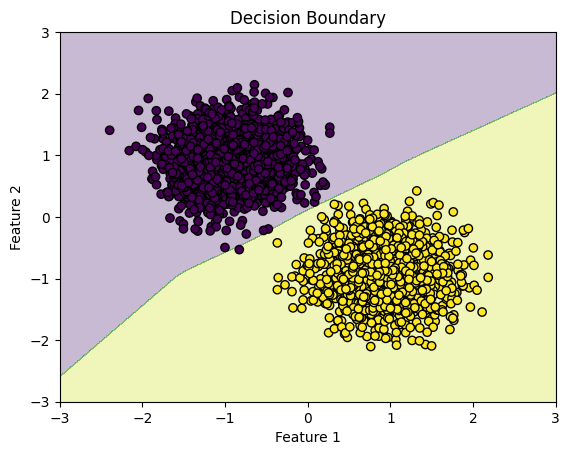

In [137]:

# Step 4: Evaluate the Model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs.data, 1)
    
    # Calculate performance metrics
    accuracy = accuracy_score(y_test_tensor, predicted)
    precision = precision_score(y_test_tensor, predicted)
    recall = recall_score(y_test_tensor, predicted)
    f1 = f1_score(y_test_tensor, predicted)
    cm = confusion_matrix(y_test_tensor, predicted)
    
    print(f'Accuracy: {accuracy * 100:.2f}%')
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1 Score: {f1:.2f}')
    print('Confusion Matrix:')
    print(cm)
    print('\nClassification Report:')
    print(classification_report(y_test_tensor, predicted))

# Plotting the decision boundary
xx, yy = np.meshgrid(np.linspace(-3, 3, 1000), np.linspace(-3, 3, 1000))
grid = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])
with torch.no_grad():
    Z = model(grid)
    _, Z = torch.max(Z.data, 1)
Z = Z.numpy().reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.3)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, edgecolors='k')
plt.title('Decision Boundary')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()
